# Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], batch[0][1].shape

([0,
  array([-0.0499387 , -0.23574989, -0.01312651,  0.29711114]),
  1.0,
  False,
  {}],
 (4,))

In [6]:
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 bool
1 0
2
1.0 1.0
2.482031038945895 -2.971094605878848


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return actions, states, targetQs

In [9]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [10]:
def model_loss(actions, states, targetQs, # model input
               action_size, hidden_size): # model init
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_onehot = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(tf.multiply(actions_logits[:-1], actions_onehot[1:]), axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs[1:]))
    #loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, labels=tf.nn.sigmoid(targetQs[1:])))    
    return actions_logits, loss

In [11]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [12]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print(np.max(actions) - np.min(actions)+1)

state size:(1000, 4) actions:(1000,)
2


In [15]:
# Training parameters
train_episodes = 1000          # max number of episodes to learn from
max_steps = 3000000000         # max steps in an episode
learning_rate = 0.001          # learning rate for adam

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
batch_size = 500               # number of samples in the memory/ experience as mini-batch size

In [16]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [19]:
# Initialize the simulation
env.reset()

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    action = env.action_space.sample()
    state, reward, done, _ = env.step(action)
    memory.buffer.append([action, state, done])
    if done is True:
        # Start new episode
        env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [20]:
state, reward, action

(array([ 0.00288584,  0.54323137, -0.06496003, -0.98449626]), 1.0, 1)

In [21]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = [] # accuracy
loss_list = [] # loss

# TF session for training
with tf.Session() as sess:
    
    # Initialize/restore variables
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Explore or exploit parameter
    total_step = 0
    
    # Training episodes/epochs
    for ep in range(train_episodes):
        
        # Start new episode
        env.reset()
        total_reward = 0
        loss_batch = []

        # Training steps/batches
        for _ in range(max_steps): # start=0, step=1, stop=max_steps/done/reward            
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            memory.buffer.append([action, state, done])
            total_reward += reward

            # Batch from NEW memory
            batch = memory.buffer
            actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            dones = np.array([each[2] for each in batch])
            
            # Calculate targetQs/nextQs
            actions_logits = sess.run(model.actions_logits, feed_dict={model.states: states})
            Qs = np.max(actions_logits, axis=1)
            targetQs = Qs * (1 - dones.astype(float))
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.actions: actions,
                                                                     model.states: states,
                                                                     model.targetQs: targetQs})
            loss_batch.append(loss)
            if done is True:
                break
                
        # At the end of each episode/epoch
        print('Episode: {}'.format(ep),
              'Total reward: {}'.format(total_reward),
              'Average loss: {:.9f}'.format(np.mean(loss_batch)),
              'Explore P: {:.9f}'.format(explore_p))
        rewards_list.append((ep, total_reward))
        loss_list.append((ep, np.mean(loss_batch)))
        
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode: 0 Total reward: 18.0 Average loss: 0.004123933 Explore P: 0.998219603
Episode: 1 Total reward: 24.0 Average loss: 0.007618526 Explore P: 0.995850720
Episode: 2 Total reward: 17.0 Average loss: 0.011519439 Explore P: 0.994176197
Episode: 3 Total reward: 18.0 Average loss: 0.020169016 Explore P: 0.992406273
Episode: 4 Total reward: 36.0 Average loss: 0.069396742 Explore P: 0.988875969
Episode: 5 Total reward: 15.0 Average loss: 0.178841993 Explore P: 0.987408756
Episode: 6 Total reward: 36.0 Average loss: 0.329504937 Explore P: 0.983896410
Episode: 7 Total reward: 32.0 Average loss: 0.893685043 Explore P: 0.980784923
Episode: 8 Total reward: 24.0 Average loss: 1.228110552 Explore P: 0.978457833
Episode: 9 Total reward: 19.0 Average loss: 2.259179592 Explore P: 0.976619510
Episode: 10 Total reward: 13.0 Average loss: 1.833285689 Explore P: 0.975363721
Episode: 11 Total reward: 14.0 Average loss: 2.801947117 Explore P: 0.974013157
Episode: 12 Total reward: 19.0 Average loss: 5.079

Episode: 97 Total reward: 26.0 Average loss: 43357937664.000000000 Explore P: 0.776400549
Episode: 98 Total reward: 24.0 Average loss: 49987448832.000000000 Explore P: 0.774563393
Episode: 99 Total reward: 53.0 Average loss: 57407123456.000000000 Explore P: 0.770521927
Episode: 100 Total reward: 21.0 Average loss: 76073197568.000000000 Explore P: 0.768926506
Episode: 101 Total reward: 16.0 Average loss: 87124877312.000000000 Explore P: 0.767713195
Episode: 102 Total reward: 20.0 Average loss: 103054614528.000000000 Explore P: 0.766199283
Episode: 103 Total reward: 30.0 Average loss: 132262731776.000000000 Explore P: 0.763934085
Episode: 104 Total reward: 17.0 Average loss: 163487809536.000000000 Explore P: 0.762653485
Episode: 105 Total reward: 19.0 Average loss: 180958691328.000000000 Explore P: 0.761224801
Episode: 106 Total reward: 23.0 Average loss: 212035158016.000000000 Explore P: 0.759498970
Episode: 107 Total reward: 41.0 Average loss: 269296795648.000000000 Explore P: 0.756432

Episode: 185 Total reward: 158.0 Average loss: 185514200137728.000000000 Explore P: 0.423064991
Episode: 186 Total reward: 200.0 Average loss: 169683554664448.000000000 Explore P: 0.414885756
Episode: 187 Total reward: 111.0 Average loss: 213968861790208.000000000 Explore P: 0.410416375
Episode: 188 Total reward: 145.0 Average loss: 202167549952000.000000000 Explore P: 0.404652229
Episode: 189 Total reward: 200.0 Average loss: 225463838441472.000000000 Explore P: 0.396837591
Episode: 190 Total reward: 195.0 Average loss: 242148930748416.000000000 Explore P: 0.389367330
Episode: 191 Total reward: 175.0 Average loss: 244719233794048.000000000 Explore P: 0.382786155
Episode: 192 Total reward: 182.0 Average loss: 300587480514560.000000000 Explore P: 0.376062815
Episode: 193 Total reward: 162.0 Average loss: 379679571705856.000000000 Explore P: 0.370180373
Episode: 194 Total reward: 164.0 Average loss: 412505939640320.000000000 Explore P: 0.364321589
Episode: 195 Total reward: 186.0 Average

Episode: 272 Total reward: 200.0 Average loss: 87548781133824.000000000 Explore P: 0.089838428
Episode: 273 Total reward: 200.0 Average loss: 104880182132736.000000000 Explore P: 0.088257521
Episode: 274 Total reward: 200.0 Average loss: 116116563165184.000000000 Explore P: 0.086707919
Episode: 275 Total reward: 200.0 Average loss: 123387389149184.000000000 Explore P: 0.085189000
Episode: 276 Total reward: 200.0 Average loss: 96500357005312.000000000 Explore P: 0.083700158
Episode: 277 Total reward: 200.0 Average loss: 95078144016384.000000000 Explore P: 0.082240797
Episode: 278 Total reward: 200.0 Average loss: 79451022950400.000000000 Explore P: 0.080810333
Episode: 279 Total reward: 200.0 Average loss: 47054395015168.000000000 Explore P: 0.079408195
Episode: 280 Total reward: 200.0 Average loss: 39384753635328.000000000 Explore P: 0.078033821
Episode: 281 Total reward: 200.0 Average loss: 52916970848256.000000000 Explore P: 0.076686661
Episode: 282 Total reward: 113.0 Average loss: 

Episode: 358 Total reward: 200.0 Average loss: 81504285753344.000000000 Explore P: 0.026049937
Episode: 359 Total reward: 200.0 Average loss: 58368660078592.000000000 Explore P: 0.025732127
Episode: 360 Total reward: 200.0 Average loss: 84972773834752.000000000 Explore P: 0.025420610
Episode: 361 Total reward: 200.0 Average loss: 91021480296448.000000000 Explore P: 0.025115262
Episode: 362 Total reward: 200.0 Average loss: 115673158123520.000000000 Explore P: 0.024815959
Episode: 363 Total reward: 200.0 Average loss: 143134516314112.000000000 Explore P: 0.024522584
Episode: 364 Total reward: 200.0 Average loss: 148768758431744.000000000 Explore P: 0.024235017
Episode: 365 Total reward: 200.0 Average loss: 179771442987008.000000000 Explore P: 0.023953145
Episode: 366 Total reward: 200.0 Average loss: 236680615297024.000000000 Explore P: 0.023676854
Episode: 367 Total reward: 200.0 Average loss: 251400206417920.000000000 Explore P: 0.023406035
Episode: 368 Total reward: 200.0 Average los

Episode: 444 Total reward: 200.0 Average loss: 351089987682304.000000000 Explore P: 0.013067322
Episode: 445 Total reward: 200.0 Average loss: 329538848423936.000000000 Explore P: 0.013006585
Episode: 446 Total reward: 200.0 Average loss: 254632370634752.000000000 Explore P: 0.012947051
Episode: 447 Total reward: 200.0 Average loss: 249794324856832.000000000 Explore P: 0.012888695
Episode: 448 Total reward: 200.0 Average loss: 406045402857472.000000000 Explore P: 0.012831495
Episode: 449 Total reward: 200.0 Average loss: 423570110939136.000000000 Explore P: 0.012775428
Episode: 450 Total reward: 200.0 Average loss: 238462691180544.000000000 Explore P: 0.012720471
Episode: 451 Total reward: 42.0 Average loss: 175816130428928.000000000 Explore P: 0.012709069
Episode: 452 Total reward: 200.0 Average loss: 150755835117568.000000000 Explore P: 0.012655426
Episode: 453 Total reward: 200.0 Average loss: 294699852103680.000000000 Explore P: 0.012602845
Episode: 454 Total reward: 200.0 Average 

Episode: 530 Total reward: 200.0 Average loss: 235538690867200.000000000 Explore P: 0.010610611
Episode: 531 Total reward: 200.0 Average loss: 122534754254848.000000000 Explore P: 0.010598520
Episode: 532 Total reward: 200.0 Average loss: 62611618004992.000000000 Explore P: 0.010586669
Episode: 533 Total reward: 200.0 Average loss: 130336797229056.000000000 Explore P: 0.010575052
Episode: 534 Total reward: 200.0 Average loss: 300281833193472.000000000 Explore P: 0.010563665
Episode: 535 Total reward: 200.0 Average loss: 369690283081728.000000000 Explore P: 0.010552504
Episode: 536 Total reward: 200.0 Average loss: 265444648812544.000000000 Explore P: 0.010541563
Episode: 537 Total reward: 200.0 Average loss: 159872255524864.000000000 Explore P: 0.010530840
Episode: 538 Total reward: 200.0 Average loss: 208273215062016.000000000 Explore P: 0.010520328
Episode: 539 Total reward: 200.0 Average loss: 321956385652736.000000000 Explore P: 0.010510025
Episode: 540 Total reward: 200.0 Average 

Episode: 616 Total reward: 200.0 Average loss: 275412882030592.000000000 Explore P: 0.010123985
Episode: 617 Total reward: 200.0 Average loss: 237557124169728.000000000 Explore P: 0.010121530
Episode: 618 Total reward: 200.0 Average loss: 168152482709504.000000000 Explore P: 0.010119123
Episode: 619 Total reward: 200.0 Average loss: 140588338905088.000000000 Explore P: 0.010116765
Episode: 620 Total reward: 200.0 Average loss: 189141820112896.000000000 Explore P: 0.010114453
Episode: 621 Total reward: 200.0 Average loss: 216706819555328.000000000 Explore P: 0.010112186
Episode: 622 Total reward: 200.0 Average loss: 258282321084416.000000000 Explore P: 0.010109965
Episode: 623 Total reward: 200.0 Average loss: 328676935729152.000000000 Explore P: 0.010107787
Episode: 624 Total reward: 200.0 Average loss: 488561119854592.000000000 Explore P: 0.010105653
Episode: 625 Total reward: 40.0 Average loss: 629214453694464.000000000 Explore P: 0.010105231
Episode: 626 Total reward: 200.0 Average 

Episode: 702 Total reward: 200.0 Average loss: 193209959448576.000000000 Explore P: 0.010024326
Episode: 703 Total reward: 197.0 Average loss: 253426004918272.000000000 Explore P: 0.010023852
Episode: 704 Total reward: 200.0 Average loss: 322977883226112.000000000 Explore P: 0.010023380
Episode: 705 Total reward: 200.0 Average loss: 337058933506048.000000000 Explore P: 0.010022917
Episode: 706 Total reward: 200.0 Average loss: 344328501198848.000000000 Explore P: 0.010022463
Episode: 707 Total reward: 200.0 Average loss: 264722121228288.000000000 Explore P: 0.010022018
Episode: 708 Total reward: 200.0 Average loss: 152092241035264.000000000 Explore P: 0.010021582
Episode: 709 Total reward: 200.0 Average loss: 84141320175616.000000000 Explore P: 0.010021155
Episode: 710 Total reward: 200.0 Average loss: 106881058078720.000000000 Explore P: 0.010020736
Episode: 711 Total reward: 200.0 Average loss: 193174811181056.000000000 Explore P: 0.010020325
Episode: 712 Total reward: 63.0 Average l

Episode: 788 Total reward: 200.0 Average loss: 307536938926080.000000000 Explore P: 0.010005046
Episode: 789 Total reward: 200.0 Average loss: 305365329641472.000000000 Explore P: 0.010004946
Episode: 790 Total reward: 200.0 Average loss: 324346602061824.000000000 Explore P: 0.010004848
Episode: 791 Total reward: 200.0 Average loss: 285251762913280.000000000 Explore P: 0.010004752
Episode: 792 Total reward: 200.0 Average loss: 207327684722688.000000000 Explore P: 0.010004658
Episode: 793 Total reward: 200.0 Average loss: 137939812089856.000000000 Explore P: 0.010004566
Episode: 794 Total reward: 200.0 Average loss: 85494511697920.000000000 Explore P: 0.010004476
Episode: 795 Total reward: 200.0 Average loss: 126303596445696.000000000 Explore P: 0.010004387
Episode: 796 Total reward: 45.0 Average loss: 264191256559616.000000000 Explore P: 0.010004367
Episode: 797 Total reward: 200.0 Average loss: 320493815070720.000000000 Explore P: 0.010004281
Episode: 798 Total reward: 200.0 Average l

Episode: 874 Total reward: 64.0 Average loss: 296448340000768.000000000 Explore P: 0.010001019
Episode: 875 Total reward: 200.0 Average loss: 313460839677952.000000000 Explore P: 0.010000999
Episode: 876 Total reward: 200.0 Average loss: 408296200601600.000000000 Explore P: 0.010000979
Episode: 877 Total reward: 200.0 Average loss: 527208443543552.000000000 Explore P: 0.010000960
Episode: 878 Total reward: 200.0 Average loss: 424869506318336.000000000 Explore P: 0.010000941
Episode: 879 Total reward: 200.0 Average loss: 272229724061696.000000000 Explore P: 0.010000922
Episode: 880 Total reward: 200.0 Average loss: 192427201658880.000000000 Explore P: 0.010000904
Episode: 881 Total reward: 200.0 Average loss: 192170795466752.000000000 Explore P: 0.010000886
Episode: 882 Total reward: 200.0 Average loss: 275293596024832.000000000 Explore P: 0.010000868
Episode: 883 Total reward: 30.0 Average loss: 364021026914304.000000000 Explore P: 0.010000866
Episode: 884 Total reward: 200.0 Average l

Episode: 960 Total reward: 200.0 Average loss: 292683096522752.000000000 Explore P: 0.010000197
Episode: 961 Total reward: 200.0 Average loss: 216868317036544.000000000 Explore P: 0.010000193
Episode: 962 Total reward: 200.0 Average loss: 197406075387904.000000000 Explore P: 0.010000190
Episode: 963 Total reward: 200.0 Average loss: 195148348653568.000000000 Explore P: 0.010000186
Episode: 964 Total reward: 200.0 Average loss: 262684830334976.000000000 Explore P: 0.010000182
Episode: 965 Total reward: 200.0 Average loss: 296104037974016.000000000 Explore P: 0.010000179
Episode: 966 Total reward: 200.0 Average loss: 295602667651072.000000000 Explore P: 0.010000175
Episode: 967 Total reward: 200.0 Average loss: 314171723874304.000000000 Explore P: 0.010000172
Episode: 968 Total reward: 200.0 Average loss: 302438678528000.000000000 Explore P: 0.010000168
Episode: 969 Total reward: 200.0 Average loss: 246343419297792.000000000 Explore P: 0.010000165
Episode: 970 Total reward: 200.0 Average

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

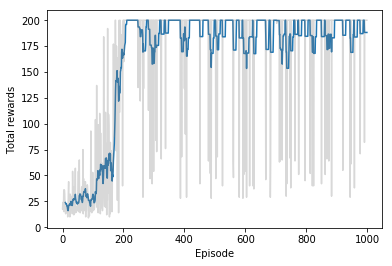

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

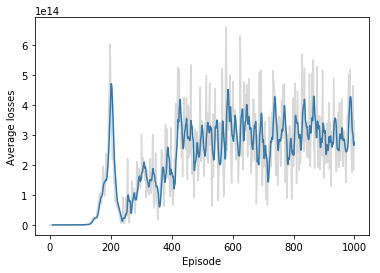

In [24]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [31]:
import gym
# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        for _ in range(111111111111111111):
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {:.2f}'.format(total_reward))
        env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 371.00


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.